In [2]:
from sentence_transformers import SentenceTransformer
import numpy as np 
from collections import defaultdict

/data/gunsbrother/anaconda3/envs/sbert3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
model_name = 'all-mpnet-base-v2'
# model_name = 'multi-qa-mpnet-base-dot-v1'
model = SentenceTransformer(model_name)

sentences = [
	"I like to play football",
	"I like to play soccer",
	"I like to play basketball",
]

#Compute embeddings
embeddings = model.encode(sentences)
sim = model.similarity(embeddings, embeddings)
print(sim)

tensor([[1.0000, 0.8451, 0.8056],
        [0.8451, 1.0000, 0.7987],
        [0.8056, 0.7987, 1.0000]])


In [4]:
import json
from pathlib import Path

FPS = 30
p_caps_dir = Path('/data/gunsbrother/prjs/ltvu/llms/LLaVA/results/egonlq/llava-v1.6-34b/global')

p_nlq_val_json = Path('/data/gunsbrother/prjs/ltvu/llms/GroundVQA/data/unified/annotations.NLQ_val.json')
nlq_data = json.load(p_nlq_val_json.open())
clip_uids = sorted(set([q['video_id'] for q in nlq_data]))

clip_uid = clip_uids[0]

queries, gts = [], []
clip_samples = list(filter(lambda x: x['video_id'] == clip_uid, nlq_data))
for q in clip_samples:
	queries.append(q['question'])
	gts.append((q['clip_start_sec'], q['clip_end_sec']))
gts = np.array(gts)
N_q = len(queries)

p_cap_data = p_caps_dir / f'{clip_uid}.json'
frame_idxs, caps = [], []
for c in json.load(p_cap_data.open())['answers']:
	frame_idxs.append(c[0])
	caps.append(c[-1])
frame_idxs = np.array(frame_idxs)
N_cap = len(frame_idxs)
gt_mask = np.zeros((N_q, N_cap), dtype=bool)
for i, (s, e) in enumerate(gts):
	s_idx, e_idx = int(s * FPS), int(e * FPS)
	s_ord = np.argmin(np.abs(frame_idxs - s_idx))
	e_ord = np.argmin(np.abs(frame_idxs - e_idx))
	gt_mask[i, s_ord:e_ord+1] = True

embs_qs = model.encode(queries)
embs_caps = model.encode(caps)
sim = model.similarity(embs_qs, embs_caps).numpy()


In [5]:
pred_width_sec = 30.
pred_cap_idxs = sim.argsort(axis=1)[:, :5]
pred_frame_idxs = frame_idxs[pred_cap_idxs]
preds = np.stack([pred_frame_idxs / FPS - pred_width_sec / 2, pred_frame_idxs / FPS + pred_width_sec / 2], axis=-1)

gts_ = gts[:, None, :]
inters = np.maximum(0, np.minimum(preds[..., 1], gts_[..., 1]) - np.maximum(preds[..., 0], gts_[..., 0]))
unions = (preds[..., 1] - preds[..., 0]) + (gts_[..., 1] - gts_[..., 0]) - inters
ious = inters / unions

ks, iou_threses = [1, 5], [0.3, 0.5]
correct_records = defaultdict(list)
for k in ks:
	for th in iou_threses:
		mask = ious >= th
		corrects = np.sum(mask[:, :k], axis=1)
		metric_name = f'R{k}@{th:.1f}'
		correct_records[metric_name].extend(corrects.tolist())
correct_records

defaultdict(list,
            {'R1@0.3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             'R1@0.5': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             'R5@0.3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             'R5@0.5': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})

In [8]:
np.set_printoptions(precision=2, suppress=True, linewidth=1000)
for l1, l2 in zip(str(sim.T).split('\n'), str(gt_mask.T.astype(int)).split('\n')):
	print(l1 + '  ' + l2)

[[0.31 0.32 0.33 0.24 0.24 0.31 0.37 0.24 0.31 0.36 0.15 0.44 0.32 0.26 0.29 0.4 ]  [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0.32 0.34 0.34 0.25 0.22 0.35 0.36 0.25 0.29 0.4  0.15 0.43 0.3  0.29 0.35 0.35]   [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0.23 0.32 0.25 0.3  0.26 0.32 0.27 0.15 0.39 0.19 0.25 0.43 0.37 0.18 0.14 0.29]   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0.34 0.31 0.36 0.28 0.25 0.35 0.36 0.22 0.3  0.31 0.17 0.44 0.33 0.2  0.24 0.38]   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0.34 0.35 0.37 0.23 0.19 0.34 0.33 0.27 0.26 0.36 0.12 0.42 0.32 0.31 0.34 0.34]   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0.33 0.33 0.4  0.25 0.22 0.37 0.37 0.24 0.28 0.4  0.11 0.46 0.34 0.32 0.35 0.37]   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0.37 0.31 0.34 0.22 0.25 0.32 0.39 0.3  0.31 0.36 0.17 0.45 0.34 0.28 0.33 0.41]   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0.41 0.36 0.43 0.28 0.27 0.42 0.4  0.28 0.32 0.37 0.2  0.49 0.41 0.29 0.37 0.4 ]   [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0.38 0.35 0.41 0.28 0.23 0.42 0.34 0.29 0.29 0

In [9]:
from sklearn.metrics import roc_auc_score

roc_auc_score(gt_mask.flatten(), sim.flatten())

0.6482758620689655

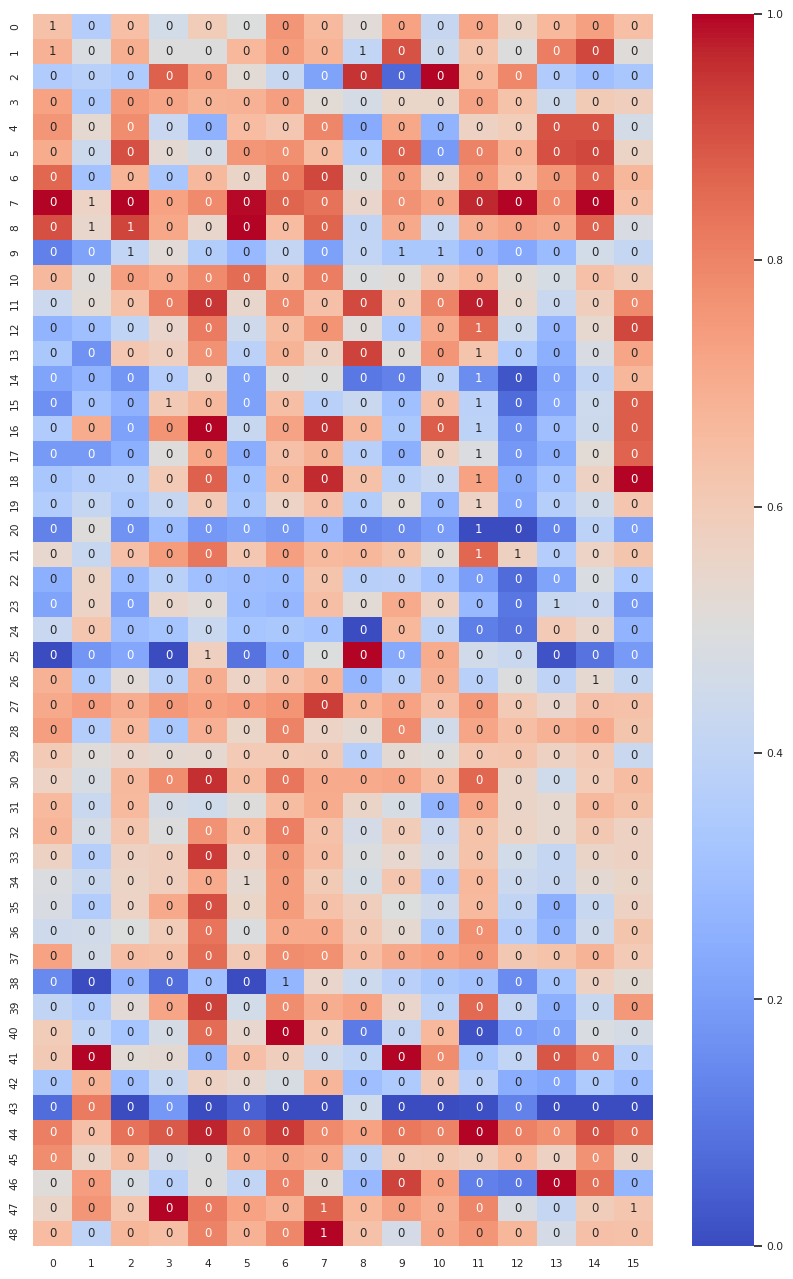

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=0.7)
plt.figure(figsize=(10, 16))
normed_sim = (sim - np.min(sim, axis=1, keepdims=True)) / (np.max(sim, axis=1, keepdims=True) - np.min(sim, axis=1, keepdims=True))
sns.heatmap(normed_sim.T, annot=gt_mask.T, fmt='d', cmap='coolwarm', vmin=0)
plt.show()

In [11]:
import pandas as pd

df = 100* pd.DataFrame({
	'all-mpnet-base-v2': [0.0141, 0.0048, 0.0571, 0.0196, 0.5678],
	'multi-qa-mpnet-base-dot-v1': [0.0097, 0.0031, 0.0558, 0.0191, 0.5578]
}, index=['R1@0.3', 'R1@0.5', 'R5@0.3', 'R5@0.5', 'AUROC']).T
print(df)
df

                            R1@0.3  R1@0.5  R5@0.3  R5@0.5  AUROC
all-mpnet-base-v2             1.41    0.48    5.71    1.96  56.78
multi-qa-mpnet-base-dot-v1    0.97    0.31    5.58    1.91  55.78


,R1@0.3,R1@0.5,R5@0.3,R5@0.5,AUROC
all-mpnet-base-v2,1.41,0.48,5.71,1.96,56.78
multi-qa-mpnet-base-dot-v1,0.97,0.31,5.58,1.91,55.78
